In [5]:
# 1) LOAD
import pandas as pd


df = pd.read_csv('spam.csv')  # <-- change to your filename

# standardize column names just in case
df.columns = [c.strip().capitalize() for c in df.columns]
assert set(df.columns) >= {"Category", "Message"}, "CSV must have Category and Message columns."

# 2) BASIC CHECKS
print("Shape:", df.shape)
print("\nNulls:\n", df.isnull().sum())
display(df.head(10))

Shape: (5572, 2)

Nulls:
 Category    0
Message     0
dtype: int64


Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...

In [7]:
# 3) PREPARE DATA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# drop empties, map labels
df = df.dropna(subset=["Category", "Message"]).copy()
df["Category"] = df["Category"].str.strip().str.lower()
label_map = {"ham":0, "spam":1}
df = df[df["Category"].isin(label_map.keys())].copy()
y = df["Category"].map(label_map).astype(int)
X = df["Message"].astype(str)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0],
      " Pos(spam) rate (train):", y_train.mean().round(3))

Train size: 4457  Test size: 1115  Pos(spam) rate (train): 0.134


In [10]:
# 4) MODELS (sparse-friendly for TF-IDF)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

pipelines = {
    "LogisticRegression": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced", random_state=42)),
    ]),
    "MultinomialNB": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", MultinomialNB()),
    ]),
    "ComplementNB": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", ComplementNB()),
    ]),
    # LinearSVC is strong; wrap in CalibratedClassifier to get predict_proba for GUI
    "LinearSVC+Calibrated": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", CalibratedClassifierCV(LinearSVC(random_state=42), cv=3)),
    ]),
    # SGDClassifier (log-loss) also works well
    "SGD (log loss)": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", SGDClassifier(loss="log_loss", class_weight="balanced", random_state=42)),
    ]),
}


In [11]:
# 5) TRAIN & EVALUATE
results = []
best_name, best_acc = None, -1.0
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    results.append((name, acc))
    if acc > best_acc:
        best_acc, best_name = acc, name
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 3))
    print(classification_report(y_test, pred, target_names=["ham","spam"], digits=3))

print("\nSUMMARY:", sorted(results, key=lambda x: x[1], reverse=True))


=== LogisticRegression ===
Accuracy: 0.983
              precision    recall  f1-score   support

         ham      0.989     0.992     0.990       966
        spam      0.945     0.926     0.936       149

    accuracy                          0.983      1115
   macro avg      0.967     0.959     0.963      1115
weighted avg      0.983     0.983     0.983      1115


=== MultinomialNB ===
Accuracy: 0.96
              precision    recall  f1-score   support

         ham      0.955     1.000     0.977       966
        spam      1.000     0.698     0.822       149

    accuracy                          0.960      1115
   macro avg      0.978     0.849     0.900      1115
weighted avg      0.961     0.960     0.957      1115


=== ComplementNB ===
Accuracy: 0.977
              precision    recall  f1-score   support

         ham      0.980     0.994     0.987       966
        spam      0.956     0.866     0.908       149

    accuracy                          0.977      1115
   macro


Best model: LinearSVC+Calibrated | Accuracy: 0.987
Confusion matrix [[TN, FP],[FN, TP]]:
 [[963   3]
 [ 11 138]]


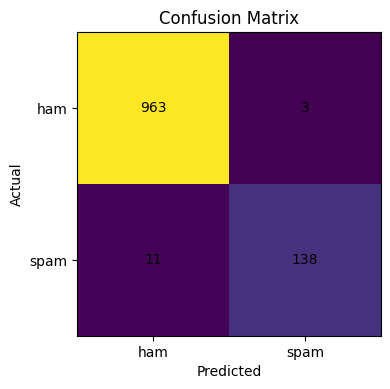

In [12]:
# 6) CONFUSION MATRIX for the best model
import matplotlib.pyplot as plt

best_pipe = pipelines[best_name]
cm = confusion_matrix(y_test, best_pipe.predict(X_test))
print(f"\nBest model: {best_name} | Accuracy: {best_acc:.3f}")
print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xticks([0,1], ["ham","spam"])
plt.yticks([0,1], ["ham","spam"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [15]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# keep the already-trained pipelines in memory
model_dd   = widgets.Dropdown(options=list(pipelines.keys()), value=best_name, description="Model:")
train_btn  = widgets.Button(description="(Re)Train", button_style="primary")
msg_in     = widgets.Textarea(
    value="WINNER!! You have won a prize. Call 09061701461 now.",
    description="Message:",
    layout=widgets.Layout(width="100%", height="80px")
)
pred_btn   = widgets.Button(description="Predict", button_style="")
out        = widgets.Output(layout={'border': '1px solid #ddd", "padding":"6px'})

state = {"pipe": best_pipe, "name": best_name, "acc": best_acc}

def on_train_clicked(_):
    with out:
        clear_output(wait=True)
        name = model_dd.value
        pipe = pipelines[name]
        pipe.fit(X_train, y_train)
        acc = accuracy_score(y_test, pipe.predict(X_test))
        state["pipe"], state["name"], state["acc"] = pipe, name, acc
        print(f"✅ Trained: {name} | Test Accuracy: {acc:.3f}")

def pred_with_proba(pipe, texts):
    # Try predict_proba; if missing, fall back to decision_function
    proba = None
    if hasattr(pipe, "predict_proba"):
        try:
            proba = pipe.predict_proba(texts)[:,1]
        except Exception:
            proba = None
    if proba is None and hasattr(pipe, "decision_function"):
        # map decision scores to pseudo-probabilities via logistic
        from scipy.special import expit
        scores = pipe.decision_function(texts)
        proba = expit(scores)  # 0..1
    return pipe.predict(texts), proba

def on_predict_clicked(_):
    with out:
        if state["pipe"] is None:
            print("Please train a model first.")
            return
        text = msg_in.value.strip()
        if not text:
            print("Type a message to classify.")
            return
        pred, proba = pred_with_proba(state["pipe"], [text])
        label = "spam" if pred[0]==1 else "ham"
        p_str = ""
        if proba is not None:
            p_str = f" | P(spam)={proba[0]:.2f}"
        print(f"Model: {state['name']} | Test Acc: {state['acc']:.3f}")
        print(f"Prediction: {label.upper()}{p_str}")

train_btn.on_click(on_train_clicked)
pred_btn.on_click(on_predict_clicked)

ui = widgets.VBox([
    widgets.HBox([model_dd, train_btn]),
    msg_in,
    pred_btn,
    out
])
display(ui)

# do one initial output line
with out:
    print(f"Ready. Current: {state['name']} (Acc {state['acc']:.3f}). Paste a message and click Predict.")

